## Indoor Positioning System
    In this notebook, we will see how to train an artificial neural network (ANN) using a PyTorch model. We will follow this procedure:

- Import the necessary modules
- Check if we have a graphics card and load the model onto it; this helps improve performance
- Load the data
- Check if we need to clean the data
- Divide the dataset into training and testing sets
- Create the ANN
- Start the training
- Start the testing
- Compare testing results with predictions

### We start importing the modules

In [2]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pathlib import Path

# Check PyTorch version
torch.__version__

'2.2.1+cu121'

### Start Setting the acces to the GPU if we have one installed

In [3]:
# Detup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Loading Data

In [4]:
dataset = pd.DataFrame()


for i in range(0, 11):
    df = pd.read_csv(f"distances_at_{i/2}m.csv")

    dataset = pd.concat([dataset, df])

#Shuffle dataset, so we can normalize the data for split into train and test
dataset = dataset.sample(n=len(dataset))

dataset = dataset.reset_index(drop=True)
dataset

,rssi,distance
0,-41,3.0
1,-40,3.5
2,-48,4.5
3,-38,4.0
4,-41,5.0
...,...,...
5495,-40,3.5
5496,-38,4.0
5497,-47,4.5
5498,-40,3.5


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rssi      5500 non-null   int64  
 1   distance  5500 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 86.1 KB


### Checking if we have Outliers

In [6]:
# Calculate the z-score for each student's height
z = np.abs(stats.zscore(dataset['rssi']))

# Identify outliers as students with a z-score greater than 3
threshold = 2.5
outliers = dataset[z > threshold]

# Print the outliers
print(outliers)



      rssi  distance
469    -68       3.0
1384   -18       0.0
2241   -72       0.0
3292   -57       4.5


### Dropping Outliers on Dataset

In [7]:
dataset = dataset.drop(outliers.index)

### Convert data to torch tensor
    Make sure the datatypes are equals

In [8]:
X = torch.from_numpy(dataset.rssi.to_numpy())
y = torch.from_numpy(dataset.distance.to_numpy())

print(f'X: {X.dtype} -- y: {y.dtype}')

X: torch.int64 -- y: torch.float64


### Splitting into training and testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

len(X_train), len(y_train),len(X_test), len(y_test)

C:\Users\saenz\AppData\Local\Temp\ipykernel_4164\3331970048.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\saenz\AppData\Local\Temp\ipykernel_4164\3331970048.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
C:\Users\saenz\AppData\Local\Temp\ipykernel_4164\3331970048.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\saenz\AppData\Local\Temp\ipyke

(4396, 4396, 1100, 1100)

In [10]:
print("Shape of X:", X.shape)

Shape of X: torch.Size([5496])


### Creating a function to plot the results

In [11]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data =X_test,
                    test_labels=y_test,
                    predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
    plt.scatter(test_data, test_labels, c='g', s=4, label='Training data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

    plt.legend(prop={'size':14})

### Plotting the raw data 

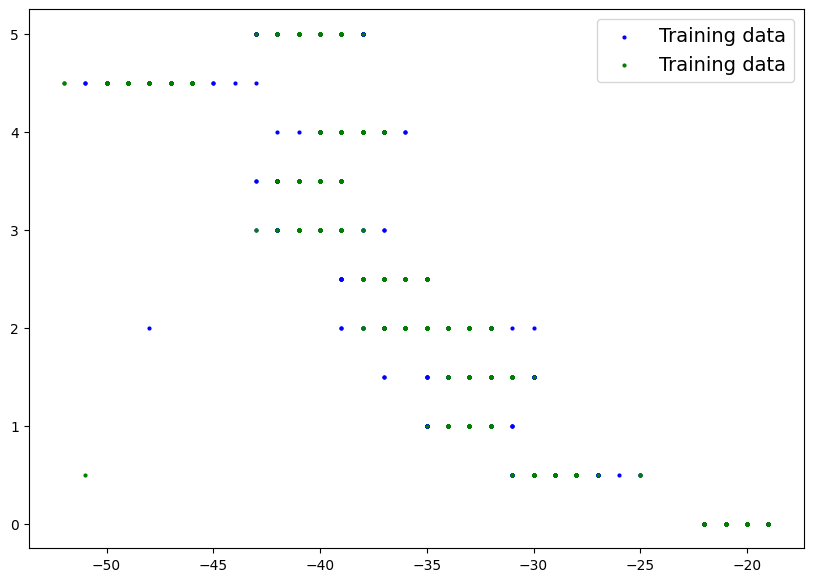

In [12]:
plot_prediction()

### Pytorch Model
This is gonna be the Artifitial Neuronal Network 

In [13]:
class RSSIToDistanceModel(nn.Module):
    def __init__(self):
        super(RSSIToDistanceModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input layer (1 feature: RSSI)
        self.fc2 = nn.Linear(64, 128)  # Hidden layer
        self.fc3 = nn.Linear(128, 64)  # Another hidden layer
        self.fc4 = nn.Linear(64, 1)   # Output layer (1 value: distance)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output for regression
        return x

In [14]:
#Create random seed
torch.manual_seed(42)

# Create an instance

model = RSSIToDistanceModel().float()  # Use float32
#list(model.parameters())

In [15]:
# List named parameters
#model.state_dict()

In [16]:
# Check the model current device
next(model.parameters()).device

device(type='cpu')

## After generate the model we move this model to a GPU just if we have one 

In [17]:
# Set the model to use the target device
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### Training
For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [18]:
# Setup loss function
loss_fn = nn.MSELoss() #same as MAE

#Setup our optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
# Let's write a training loop
torch.manual_seed(42)

batch_size = 32

# Create datasets and DataLoaders
train_dataset = TensorDataset(X_train.clone().detach().view(-1, 1).to(torch.float32), y_train.clone().detach())
test_dataset = TensorDataset(X_test.clone().detach().view(-1, 1).to(torch.float32), y_test.clone().detach())


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()  # Training mode
    running_loss = 0.0
    
    for rssi_batch, distance_batch in train_loader:

        rssi_batch = rssi_batch.to(device)
        distance_batch = distance_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(rssi_batch)
        loss = loss_fn(outputs, distance_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.5f}')



Epoch [1/100], Loss: 3.29950
Epoch [2/100], Loss: 1.35099
Epoch [3/100], Loss: 1.34864
Epoch [4/100], Loss: 1.34501
Epoch [5/100], Loss: 1.33370
Epoch [6/100], Loss: 1.32898
Epoch [7/100], Loss: 1.32253
Epoch [8/100], Loss: 1.31075
Epoch [9/100], Loss: 1.30371
Epoch [10/100], Loss: 1.29038
Epoch [11/100], Loss: 1.28233
Epoch [12/100], Loss: 1.26819
Epoch [13/100], Loss: 1.25194
Epoch [14/100], Loss: 1.23364
Epoch [15/100], Loss: 1.21567
Epoch [16/100], Loss: 1.19339
Epoch [17/100], Loss: 1.16745
Epoch [18/100], Loss: 1.13022
Epoch [19/100], Loss: 1.09494
Epoch [20/100], Loss: 1.05737
Epoch [21/100], Loss: 1.03265
Epoch [22/100], Loss: 0.97524
Epoch [23/100], Loss: 0.93143
Epoch [24/100], Loss: 0.89208
Epoch [25/100], Loss: 0.84839
Epoch [26/100], Loss: 0.80718
Epoch [27/100], Loss: 0.76216
Epoch [28/100], Loss: 0.72856
Epoch [29/100], Loss: 0.70102
Epoch [30/100], Loss: 0.67276
Epoch [31/100], Loss: 0.66312
Epoch [32/100], Loss: 0.63974
Epoch [33/100], Loss: 0.63071
Epoch [34/100], Los

### Testing

In [20]:
test_dataset = TensorDataset(X_test.clone().detach().view(-1, 1).to(torch.float32), y_test.clone().detach())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Prepare to store the predicted values 
predictions = []

model.eval()  # Set the model to evaluation mode

test_loss = 0.0
with torch.inference_mode():  # No need to calculate gradients during testing
    for rssi_batch, distance_batch in test_loader:
        # Move data to GPU if available
        rssi_batch = rssi_batch.to(device)
        distance_batch = distance_batch.to(device)
        
        # Forward pass
        outputs = model(rssi_batch)
        loss = loss_fn(outputs, distance_batch)
        
        test_loss += loss.item()

        predictions.append(outputs.cpu())

# Print test loss
print(f'Test Loss: {test_loss / len(test_loader):.4f}')

# Concatenate all the predictions into a single tensor
predictions = torch.cat(predictions, dim=0)

# Optional: Convert predictions to numpy array if needed
predictions_numpy = predictions.numpy()

# Now `predictions` contains the predicted values for the test set
print("Predictions shape:", predictions.shape)  # Should be [number_of_test_samples, 1]

Test Loss: 0.4307
Predictions shape: torch.Size([1100, 1])


In [21]:
model.eval()

value = [-34]
value = torch.tensor(value, dtype=torch.float32)
value
with torch.inference_mode():
    test = model(value.to(device))

print(test)

tensor([1.9244], device='cuda:0')


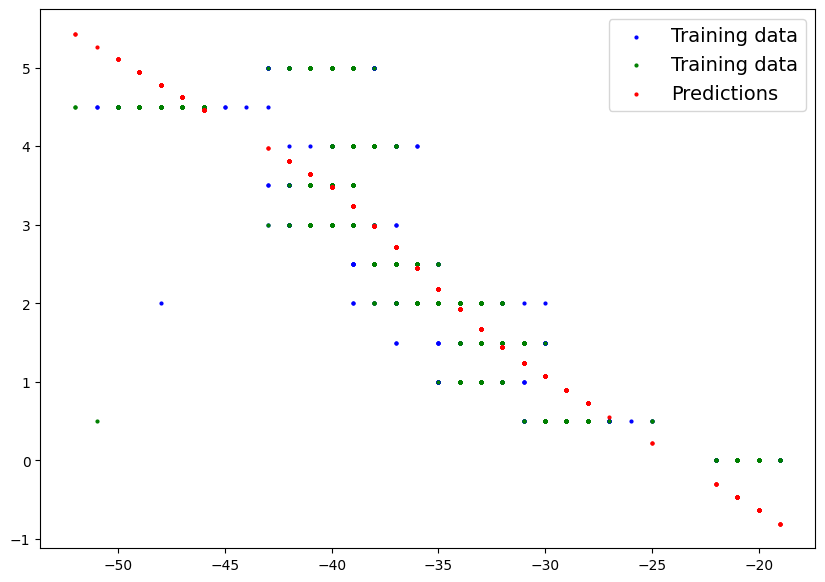

In [22]:
plot_prediction(predictions=predictions)

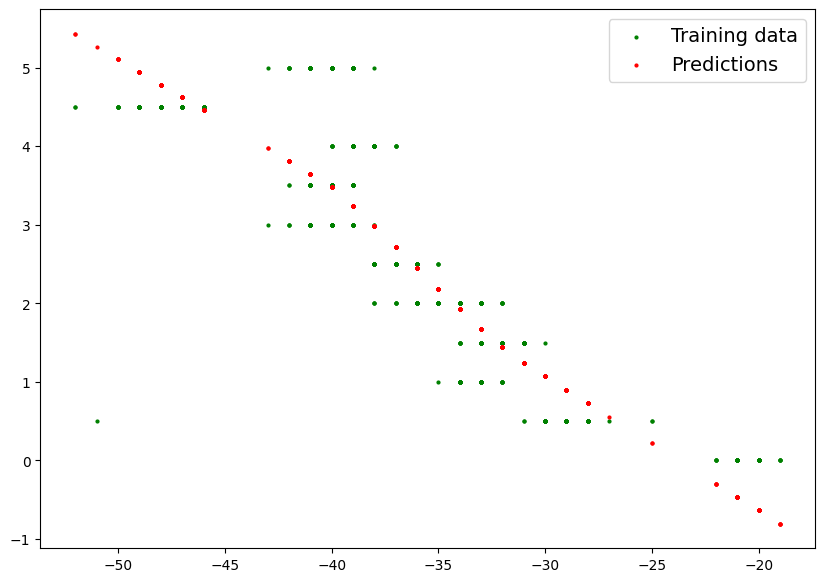

In [23]:
plt.figure(figsize=(10,7))
plt.scatter(X_test.cpu(), y_test, c='g', s=4, label='Training data')
plt.scatter(X_test.cpu(), predictions, c='r', s=4, label="Predictions")

plt.legend(prop={'size':14})

In [24]:
print(X_test, predictions)

tensor([-38., -37., -29.,  ..., -35., -31., -39.]) tensor([[2.9797],
        [2.7159],
        [0.9001],
        ...,
        [2.1882],
        [1.2417],
        [3.2436]])
